In [1]:
import random
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection as fdr
from statsmodels.regression.linear_model import OLSResults
import dateutil

In [2]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 
                            1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

In [3]:
# https://www.statsmodels.org/stable/mixed_linear.html
data = sm.datasets.get_rdataset("dietox", "geepack").data
display(data)

md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])

mdf = md.fit()

print(mdf.summary())

C:\Users\ben\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Likelihood:         -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            



In [4]:
df = fr_filt
df2 = np.log2(df[fr_quant_filenames_in_analytical_order].T)
fg = file_grouping[file_grouping['fr_name'].isin(fr_quant_filenames_in_analytical_order)]
fg = fg.reset_index()[['fr_name', 'rat_label', 'bg_type', 'glucose_tolerance', 'bg']].set_index('fr_name')
df = df2.join(fg)
ogtt_lookup = animal_phenotypes[['animal', 'OGTT (AUC)']]
df['ogtt'] = df['rat_label'].apply(lambda x: ogtt_lookup[ogtt_lookup['animal'] == (int(x))]['OGTT (AUC)'].values[0])
# rename columns to remove '.' because it messes with the formula notation 
new_cols = {}
for col in df.columns:
    new_cols[col] = col.replace('.', '').replace(':', '').replace('-', '')\
    .replace('[', '').replace(']', '')
df = df.rename(new_cols, axis=1)
display(df)

,unknown_67905463_0536,unknown_6411087_0537,unknown_95115973_0541,unknown_32903067_0542,unknown_96913147_0544,unknown_62313641_0546,unknown_29108359_0551,unknown_35299652_0553,unknown_24709372_0554,unknown_60514441_0555,...,unknown_89782532_20148,unknown_9749118_20163,unknown_59358716_20175,unknown_87180945_20196,unknown_100393829_20435,rat_label,bg_type,glucose_tolerance,bg,ogtt
20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),20.405355,21.533648,20.665848,24.400930,19.378685,23.049698,28.481360,19.316892,24.328078,19.478253,...,18.897008,16.810111,17.724121,18.400646,16.655211,1076.0,FBG,diabetic,71.000000,2321.25
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),23.313111,24.586227,23.731244,26.811664,22.709669,26.254519,30.305095,22.008084,26.237893,23.669177,...,19.348489,17.364343,19.240306,18.585339,16.313637,1062.0,FBG,impaired,52.333333,1648.75
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),23.218699,24.375151,23.038733,26.708762,21.722467,26.085255,29.595696,22.149967,25.628550,23.638288,...,21.529536,20.099612,21.430516,20.968101,19.339229,1093.0,FBG,normal,64.000000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),24.012349,25.685664,24.916555,25.977120,23.985839,27.293718,31.938325,22.246767,27.005584,24.827176,...,17.921098,18.430542,17.488155,16.202162,17.985491,1060.0,RBG,impaired,225.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),24.302356,25.422294,24.042666,27.313654,22.321161,26.913271,30.455412,22.475813,26.363764,23.854459,...,20.133479,17.986741,19.996615,19.778245,17.357845,1091.0,FBG,normal,48.500000,846.75
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),23.901455,24.936916,24.162971,27.337061,23.184906,26.682437,30.690269,22.495336,26.325506,23.984926,...,17.824376,18.099621,17.383197,15.556400,17.582655,1092.0,RBG,impaired,70.500000,1377.95
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),23.883301,24.779941,23.627979,27.415597,22.795191,26.236176,29.854529,22.337295,25.798043,23.349277,...,18.836779,18.145468,18.282680,16.603878,17.887551,1093.0,RBG,normal,69.500000,993.00
20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),23.387975,24.696276,24.085858,27.230430,22.878785,26.307266,30.106764,22.612902,26.021376,23.659766,...,19.255315,14.496938,19.507853,19.379093,13.846921,1082.0,FBG,diabetic,50.000000,2224.75
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),24.421692,25.054941,23.169508,27.598719,22.397716,26.123572,29.717328,22.790052,25.559916,22.258087,...,18.261890,18.854601,17.718258,16.494586,18.466842,1060.0,RBG,impaired,83.000000,1761.75
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),23.463756,24.934805,24.010849,27.126653,22.703282,26.680311,30.314104,22.526302,26.226352,24.184003,...,19.685160,18.324624,19.526233,18.844052,17.739443,1101.0,FBG,diabetic,43.000000,2015.75


In [5]:
random_col = random.choice(df.drop(df.filter(regex='unknown').columns, axis=1).columns)
print(random_col)

lmem_continuous = smf.mixedlm(f"{random_col} ~ ogtt * bg_type", df, groups=df['rat_label']).fit(maxiter=100)
print(lmem_continuous.summary(), "\n\n")

lmem_categorical = smf.mixedlm(f"{random_col} ~ glucose_tolerance * bg_type", df, groups=df['rat_label']).fit(maxiter=100)
print(lmem_categorical.summary())

TG_160_180_180_88083392_19251
                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TG_160_180_180_88083392_19251
No. Observations: 60      Method:             REML                         
No. Groups:       10      Scale:              0.6199                       
Min. group size:  6       Likelihood:         -88.9531                     
Max. group size:  6       Converged:          Yes                          
Mean group size:  6.0                                                      
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                21.455      0.699   30.696   0.000   20.085   22.825
bg_type[T.RBG]           -2.005      0.739   -2.715   0.007   -3.453   -0.557
ogtt                      0.000      0.000    0.598   0.550   -0.00

In [74]:
vars(lmem_categorical)

{'_results': <statsmodels.regression.mixed_linear_model.MixedLMResults at 0x2070a97d808>,
 '__doc__': '\n    Class to contain results of fitting a linear mixed effects model.\n\n    MixedLMResults inherits from statsmodels.LikelihoodModelResults\n\n    Parameters\n    ----------\n    See statsmodels.LikelihoodModelResults\n\n    Attributes\n    ----------\n    model : class instance\n        Pointer to MixedLM model instance that called fit.\n    normalized_cov_params : array\n        The sampling covariance matrix of the estimates\n    params : array\n        A packed parameter vector for the profile parameterization.\n        The first `k_fe` elements are the estimated fixed effects\n        coefficients.  The remaining elements are the estimated\n        variance parameters.  The variance parameters are all divided\n        by `scale` and are not the variance parameters shown\n        in the summary.\n    fe_params : array\n        The fitted fixed-effects coefficients\n    cov_re :

In [12]:
print(lmem_continuous.aic)
print(lmem_continuous.bic)
print(lmem_continuous.bootstrap)
print(lmem_continuous.bse)
print(lmem_continuous.bse_fe)
print(lmem_continuous.bse_re)
# print(lmem_continuous.bsejac)
# print(lmem_continuous.bsejhj)
print(lmem_continuous.conf_int)
print(lmem_continuous.converged)
print(lmem_continuous.cov_params())


nan
nan
<bound method ResultMixin.bootstrap of <statsmodels.regression.mixed_linear_model.MixedLMResults object at 0x000002769F549348>>
Intercept              0.224500
bg_type[T.RBG]         0.283352
ogtt                   0.000133
ogtt:bg_type[T.RBG]    0.000167
Group Var              0.192842
dtype: float64
Intercept              0.224500
bg_type[T.RBG]         0.283352
ogtt                   0.000133
ogtt:bg_type[T.RBG]    0.000167
dtype: float64
Group Var    0.058233
dtype: float64
<bound method LikelihoodModelResults.conf_int of <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x000002769FCE78C8>>
False
                        Intercept  bg_type[T.RBG]          ogtt  \
Intercept            5.040041e-02   -4.014404e-02 -2.861712e-05   
bg_type[T.RBG]      -4.014404e-02    8.028809e-02  2.279360e-05   
ogtt                -2.861712e-05    2.279360e-05  1.757976e-08   
ogtt:bg_type[T.RBG]  2.279360e-05   -4.558721e-05 -1.400232e-08   
Group Var           -1.

In [16]:
import warnings
warnings.filterwarnings('ignore')

# populate dictionaries with the results of fitting each feature with mixed effects model 
cont = {}
categorical = {}
i=0
for col in df.iloc[:, 0:-5]:
    cont[col] = smf.mixedlm(f"{col} ~ ogtt * bg_type", df, groups=df['rat_label']).fit(maxiter=100)

    categorical[col] = smf.mixedlm(f"{col} ~ glucose_tolerance * bg_type", df, groups=df['rat_label']).fit(maxiter=100)
    i += 1
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000


In [21]:
v = list(cont.values())[0]
v.pvalues

Intercept              0.000000
bg_type[T.RBG]         0.622820
ogtt                   0.249154
ogtt:bg_type[T.RBG]    0.828446
Group Var                   NaN
dtype: float64

In [6]:
# Save each fitted model in a pickle
# pickle.dump(cont, open(r'..\data\interim\lmem_lipidomics_results_continuous.bin', 'wb'))
# pickle.dump(categorical, open(r'..\data\interim\lmem_lipidomics_results_categorical.bin', 'wb'))

# Load pickled model files 
cont = pickle.load(open(r'..\data\interim\lmem_lipidomics_results_continuous.bin', 'rb'))
categorical = pickle.load(open(r'..\data\interim\lmem_lipidomics_results_categorical.bin', 'rb'))

In [22]:
pd.DataFrame().from_dict

<bound method DataFrame.from_dict of <class 'pandas.core.frame.DataFrame'>>

In [8]:
list(cont.items())[55][1].

In [38]:
pd.DataFrame.append?

In [10]:
lmem_continuous.bse.append(lmem_continuous.bse_fe)

Intercept              0.698956
bg_type[T.RBG]         0.738785
ogtt                   0.000413
ogtt:bg_type[T.RBG]    0.000436
Group Var              0.232257
Intercept              0.698956
bg_type[T.RBG]         0.738785
ogtt                   0.000413
ogtt:bg_type[T.RBG]    0.000436
dtype: float64

In [32]:
# print(lmem_continuous.aic, type(lmem_continuous.aic))
# print(lmem_continuous.bic, type(lmem_continuous.bic))
# print(lmem_continuous.bootstrap, type(lmem_continuous.bootstrap))
print(lmem_continuous.bse, type(lmem_continuous.bse))
print(lmem_continuous.bse_fe, type(lmem_continuous.bse_fe))
print(lmem_continuous.bse_re, type(lmem_continuous.bse_re))
# print(lmem_continuous.bsejac)
# print(lmem_continuous.bsejhj)
print(lmem_continuous.conf_int, type(lmem_continuous.conf_int))
print(lmem_continuous.converged, type(lmem_continuous.converged))
print(lmem_continuous.cov_params(), type(lmem_continuous.cov_params()))

Intercept              0.224500
bg_type[T.RBG]         0.283352
ogtt                   0.000133
ogtt:bg_type[T.RBG]    0.000167
Group Var              0.192842
dtype: float64 <class 'pandas.core.series.Series'>
Intercept              0.224500
bg_type[T.RBG]         0.283352
ogtt                   0.000133
ogtt:bg_type[T.RBG]    0.000167
dtype: float64 <class 'pandas.core.series.Series'>
Group Var    0.058233
dtype: float64 <class 'pandas.core.series.Series'>
<bound method LikelihoodModelResults.conf_int of <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper object at 0x000002769FCE78C8>> <class 'method'>
False <class 'bool'>
                        Intercept  bg_type[T.RBG]          ogtt  \
Intercept            5.040041e-02   -4.014404e-02 -2.861712e-05   
bg_type[T.RBG]      -4.014404e-02    8.028809e-02  2.279360e-05   
ogtt                -2.861712e-05    2.279360e-05  1.757976e-08   
ogtt:bg_type[T.RBG]  2.279360e-05   -4.558721e-05 -1.400232e-08   
Group Var          

In [19]:
lmem_continuous.converged

True

In [27]:
pd.Series({'converged': True}).astype('bool').append(pd.Series({1:0}))

converged    1
1            0
dtype: int64

Index(['Intercept', 'bg_type[T.RBG]', 'ogtt', 'ogtt:bg_type[T.RBG]',
       'Group Var', 'converged'],
      dtype='object')


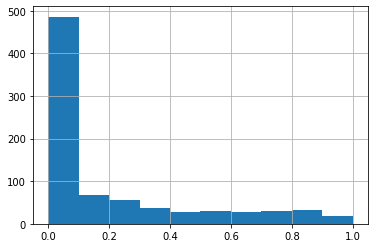

In [20]:
d = {}
for feature, model in cont.items():
#     print(model.pvalues['bg_type[T.RBG]'])
    d[feature] = model.pvalues.append(pd.Series({'converged': model.converged}))

cont_pvals = pd.DataFrame().from_dict(d, orient='index')
print(cont_pvals.columns)
cont_pvals[cont_pvals['converged'] == True]['ogtt:bg_type[T.RBG]'].hist()

In [34]:
cont_pvals[cont_pvals['converged'] == True]

,Intercept,bg_type[T.RBG],ogtt,ogtt:bg_type[T.RBG],Group Var,converged
unknown_67905463_0536,0.000000e+00,6.228201e-01,0.249154,0.828446,NaN,1.0
unknown_6411087_0537,0.000000e+00,6.664220e-01,0.715096,0.694011,1.000000,1.0
unknown_32903067_0542,0.000000e+00,9.344545e-01,0.225233,0.520479,1.000000,1.0
unknown_96913147_0544,0.000000e+00,6.108830e-01,0.493124,0.265155,1.000000,1.0
unknown_62313641_0546,0.000000e+00,6.708277e-01,0.672770,0.656733,NaN,1.0
...,...,...,...,...,...,...
unknown_94889648_20144,6.701079e-105,3.729074e-04,0.077205,0.000015,0.426834,1.0
unknown_89782532_20148,1.003305e-237,1.495178e-10,0.167095,0.000012,0.240032,1.0
unknown_9749118_20163,1.055881e-114,4.001611e-03,0.220468,0.000087,0.348479,1.0
unknown_87180945_20196,4.953279e-153,1.689668e-15,0.400807,0.000047,0.212041,1.0


# FDR Calculation on the p-values directly from the MixedLM object
### How do they calculate these p-values? Uncertain

In [60]:
pd.DataFrame(fdr(cont_pvals['ogtt:bg_type[T.RBG]'].sort_values(ascending=True), is_sorted=True, alpha=0.05)[0]).value_counts()

False    598
True     431
dtype: int64

# Calculating likelihood ratio test on the nested model 
### Nested model is the one that uses fewer predictors (a little counterintuitive) 
https://www.statisticshowto.com/likelihood-ratio-tests/

In [69]:
v.llf

-68.34632840498301

In [68]:
# Likelihood test to determine model's significance and effect size of a more-restricted model vs less-restricted
# More restricted model has more terms in the cross (both of Diabetic status/OGTT AND fasted/random-fed)
# Less restricted model drops one of those terms (making the formula I ~ OGTT + (1|Animal)) or I ~ feed-type + (1|Animal)

OLSResults().compare_lr_test(restricted = v)

TypeError: __init__() missing 2 required positional arguments: 'model' and 'params'

## The OLSResults() thing is confusing, so try doing the likelihood ratio manually
### llf attribute of the mixed model object = LLF = log likelihood function = the value of that function
https://scientificallysound.org/2017/08/24/the-likelihood-ratio-test-relevance-and-application/

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

# import example dataset
data = sm.datasets.get_rdataset("dietox", "geepack").data

# fit time only to pig weight
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit(reml=False)
print(mdf.summary())
llf = mdf.llf

# fit time and litter to pig weight
mdlitter = smf.mixedlm("Weight ~ Time + Litter", data, groups=data["Pig"])
mdflitter = mdlitter.fit(reml=False)
print(mdflitter.summary())
llflitter = mdflitter.llf

lr, p = lrtest(llf, llflitter)
print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             ML        
No. Groups:       72      Scale:              11.3525   
Min. group size:  11      Log-Likelihood:     -2402.9325
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.783  20.083 0.000 14.189 17.258
Time          6.943    0.033 208.071 0.000  6.877  7.008
Group Var    39.821    2.107                            

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             ML        
No. Groups:       72      Scale:              11.3525   
Min. group size:  11      Log-Likelihood:     -240

In [28]:
cont_pvals[cont_pvals['ogtt:bg_type[T.RBG]'] < 0.05].shape

(503, 5)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'bg_type[T.RBG]'}>],
       [<AxesSubplot:title={'center':'ogtt'}>,
        <AxesSubplot:title={'center':'ogtt:bg_type[T.RBG]'}>],
       [<AxesSubplot:title={'center':'Group Var'}>, <AxesSubplot:>]],
      dtype=object)

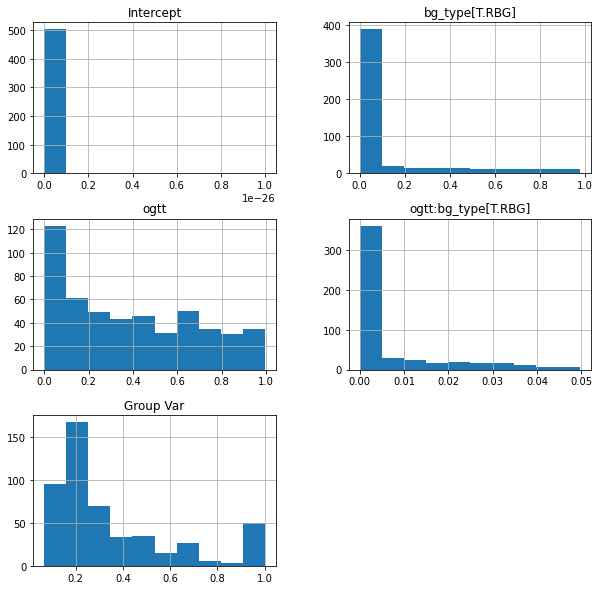

In [41]:
cont_pvals[cont_pvals['ogtt:bg_type[T.RBG]'] < 0.05].hist(figsize=(10,10))

In [82]:
cont_pvals['ogtt:bg_type[T.RBG]'].sort_values()

unknown_108179688_13387                2.093050e-14
unknown_91372266_15818                 2.733639e-11
unknown_81670746_14907                 7.955257e-11
unknown_99477686_14113                 1.739453e-10
unknown_96876172_13829                 1.761591e-10
                                           ...     
unknown_61018481_9392                  9.801676e-01
unknown_65957367_1758                  9.867361e-01
unknown_4303898_5212                   9.926188e-01
PlasmanylPC_O180_204_79662323_10082    9.973926e-01
unknown_68555347_13608                 9.997528e-01
Name: ogtt:bg_type[T.RBG], Length: 1029, dtype: float64

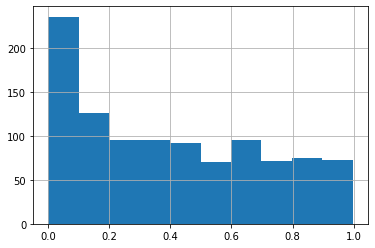

In [59]:
cont_pvals['ogtt'].hist()

In [60]:
d = {}
for feature, model in categorical.items():
#     print(model.pvalues['bg_type[T.RBG]'])
    d[feature] = model.pvalues
    ################ pd.concat or pd.append all the data outputs into one series, then make a DF from that 

cate_pvals = pd.DataFrame.from_dict(d, orient='index')
cate_pvals

,Intercept,glucose_tolerance[T.impaired],glucose_tolerance[T.normal],bg_type[T.RBG],glucose_tolerance[T.impaired]:bg_type[T.RBG],glucose_tolerance[T.normal]:bg_type[T.RBG],Group Var
unknown_67905463_0536,0.000000e+00,0.552901,0.177011,7.696863e-02,0.702413,0.627727,NaN
unknown_6411087_0537,0.000000e+00,0.592782,0.694984,7.151380e-01,0.637370,0.908535,1.000000
unknown_95115973_0541,0.000000e+00,0.933355,0.941052,2.954694e-01,0.831653,0.623403,NaN
unknown_32903067_0542,0.000000e+00,0.414223,0.411584,8.589627e-02,0.433948,0.568256,1.000000
unknown_96913147_0544,0.000000e+00,0.090210,0.589971,1.887219e-02,0.136542,0.368798,1.000000
...,...,...,...,...,...,...,...
unknown_89782532_20148,0.000000e+00,0.405183,0.047375,4.895340e-01,0.000134,0.000024,0.258736
unknown_9749118_20163,3.783054e-310,0.114931,0.174453,3.733471e-07,0.000521,0.000457,0.277407
unknown_59358716_20175,0.000000e+00,0.309421,0.056746,3.104837e-01,0.000064,0.000023,0.371336
unknown_87180945_20196,0.000000e+00,0.850441,0.104404,4.516217e-06,0.000187,0.000094,0.275860


### To compare whether the effect is significant, use log likelihood (more safe) or Tukey's test

In [61]:
lmem_categorical.

NameError: name 'lmem' is not defined

In [124]:
random_col

'unknown_9208653_19525'

In [140]:
no_warning_features = ['unknown_9208653_19525', 'TG_524_8727702_16817', 'TG_566_92480176_16736']